In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
GDRIVE_DIR = '/content/gdrive/MyDrive/LCC_structured_task'

Mounted at /content/gdrive


In [ ]:
!pip install -q transformers
!pip install -U -q sentence-transformers
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 3.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
import pickle
from sentence_transformers import SentenceTransformer
import warnings
import gensim
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
# Download and extract the data and learn_decoder.py
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56" -O files.zip && rm -rf /tmp/cookies.txt
!wget --header="Host: drive.usercontent.google.com" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7" --header="Accept-Language: en-US,en;q=0.9,he;q=0.8" --header="Cookie: HSID=AHJfxja1o67aaDDKP; SSID=AcFaYUEeiC88MwrF9; APISID=-FXvHmBvJ828Jrpq/AaIp_RI6gKwBAA-zy; SAPISID=_psqReiv0O2WdiVv/AhLpZThJtVNAPgAJP; __Secure-1PAPISID=_psqReiv0O2WdiVv/AhLpZThJtVNAPgAJP; __Secure-3PAPISID=_psqReiv0O2WdiVv/AhLpZThJtVNAPgAJP; S=billing-ui-v3=pX9aAWC8SzxQZfQvQ-0SbCFRz65PPkVY:billing-ui-v3-efe=pX9aAWC8SzxQZfQvQ-0SbCFRz65PPkVY:maestro=dsv3G-owxPD6uTATLH0lBQZNadhFo6ZKJiuB9usoQVU; __Secure-BUCKET=CPgG; SID=g.a000kggtmVDh8D92rqHe5fiG-bMoXQw7Ld8Tf_C8qHhSE2ZoFUyx_uObP_F4bCqI8I561ccGMwACgYKAWESARQSFQHGX2Mi5DnhBiJ2gjjbMSP0XJbU5BoVAUF8yKrlBjWMdNOfGnmA7TZzmbWD0076; __Secure-1PSID=g.a000kggtmVDh8D92rqHe5fiG-bMoXQw7Ld8Tf_C8qHhSE2ZoFUyx2BFINS8lXhFUyAFwuvl8CQACgYKAW4SARQSFQHGX2MiWd6bHkI0JN89-1dFZUbS2hoVAUF8yKpc-H3AD8N6tj-dmFG21SeE0076; __Secure-3PSID=g.a000kggtmVDh8D92rqHe5fiG-bMoXQw7Ld8Tf_C8qHhSE2ZoFUyxJl_TGsCsjeiVN72q3lSCWQACgYKASASARQSFQHGX2MiULluXa7aABDwxgCWjB6IyhoVAUF8yKoy_HHYLCqIFMwNjx-GwYWe0076; __Secure-ENID=20.SE=jyM_w2hA8DW6FvPOh9wudde93a0A9P41Epzo098LV_LyU79-VVcJ9K-vNLrhCLuVzi69CyV4RxlSls8AAT9J8odwIXi_ISVn8Z1U1DH52BC3YiwOwO9LKUsBesCbGx2D6u1XwZ5GIP_PZMo1tkLLJq2VCtcxRP9OtC_QgHNbAD4eyc1TTu1C8XbZLFTOIgb0k9IfM2bMBXeha6t3sJysARZWpDIzs3I8wWZ5JtABB253grtjQyCnxyy9MUgTcYAVaoEGwgVHV4V4lSY6gydFkO2gYxl7JqYloqCq74HahGK54TBlsGZIOTM_KvFAsIidcrPaVOBpH6IGQTPChxy3Tr-GLK7VpBiQ8JW7V0xC8XTN1crEaaZnGFQ6MrjDv8f3hCY0Kg; AEC=AQTF6HwEtUB747fVHMzvOWJV9pmRoGs8Ix8FJ1HTrxbE9NY1dtyro2AvNQ; NID=515=Wdt0NWZqVSh3TtdIfjXCGTCCkj7jaJjt-lkOL3hLD_hPSSMyGxKkVthECwGGFbbxmvfM2iKZ1SkPGDVgLwjghAOrV9Ya7iEJJ0eSXZSfszc0WxRXm3Jy6LxqPEZLmY8v3AIkMX-o8KE5ZRXGEzgv_s9pfgS8bmeiIGT13Iiyw9tPzRZDChGijNbZ0Mp1oF-4YKikOZCyo8Km9wXOgLAC9dbeIqAlTdER97cQ7B5GajyRLH_bFrg0lCVN4tyZEycjihHOu6Eq_V88rswgV7uvzemJ_yk4WbbIWJVm9NCO4tWdDQG8NY3EY57xAJbmIhu260jDftYwzjCnpqJ8C1iCm-FjboF6xJwKJEtLkCXagIcSWxfPGqRWIn5KY72ogAMZTlUZ5RE5F8bH4sFgkt5pW_AalY5mxYPOfZgF-9hcJYsF71rMOic6mqSfvR8iNo-k6_SZ-4o5WkYxbwdLgiaIOiCJHkhIGBoXsm5hh5BHDqlk5ERGnFn5zpqOguNLJFjXT3nhaP1g_a2fFvd0bmZw2A9Y6tBNAC7CbDOmSHSmYmLag0qVcqu286CZh5svuhdM-QPcSCt5u0kPgfWN3KBha0G9L9qCiDIwntvnlVNoUYLBM4je1bhGjO9M2tdH_vteLo4vjm9Cq-4I2A; __Secure-1PSIDTS=sidts-CjIB3EgAEi6AJoaJlu_IOdqmparuSFUne3RqD5YKK5hcqKjRlc0CTp9lSpyH2OoVVoqmlxAA; __Secure-3PSIDTS=sidts-CjIB3EgAEi6AJoaJlu_IOdqmparuSFUne3RqD5YKK5hcqKjRlc0CTp9lSpyH2OoVVoqmlxAA; SIDCC=AKEyXzW7IJ8miV8hX_pqzqqPW7--eMWuWfausspLBoDPlfZDCRZDED56ohpancLYOBPizfUzi1aM; __Secure-1PSIDCC=AKEyXzVGnmSuG07J22njRVFPQ_sk88MgnqtYxJd-M0_9Pz3jdh4GpGPhPOqCMrayTU9SJTW3n54; __Secure-3PSIDCC=AKEyXzVScJYbKdtIImPYKpTRkExsc5UhC5n9Rkk8wNFlMZNW3_xkvWlimAXWaZ4T7kTcJy5AE4I" --header="Connection: keep-alive" "https://drive.usercontent.google.com/download?id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56&export=download&authuser=0&confirm=t&uuid=efeb9ce5-a5c5-453b-938d-6c0ece963f3c&at=APZUnTV18b5mSao0MQ2JbtpefTxr%3A1719665236172" -c -O 'files.zip'
!unzip files.zip
!rm files.zip

--2024-08-24 16:41:53--  https://drive.usercontent.google.com/download?id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56&export=download&authuser=0&confirm=t&uuid=efeb9ce5-a5c5-453b-938d-6c0ece963f3c&at=APZUnTV18b5mSao0MQ2JbtpefTxr%3A1719665236172
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.26.132, 2607:f8b0:400c:c04::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.26.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97708666 (93M) [application/octet-stream]
Saving to: ‘files.zip’

files.zip           100%[===================>]  93.18M  89.1MB/s    in 1.0s    

2024-08-24 16:41:54 (89.1 MB/s) - ‘files.zip’ saved [97708666/97708666]

Archive:  files.zip
  inflating: stimuli_180concepts.txt  
  inflating: learn_decoder.py        
  inflating: vectors_180concepts.GV42B300.txt  
  inflating: imaging_data.csv        


In [ ]:
# Loading the functions from learn_decoder.py
from learn_decoder import *

In [ ]:
def open_pkl(path):
  with open(path , 'rb') as f:
    data = pickle.load(f)
  return data

In [ ]:
def load_and_process_text_file(filepath):
  # Open the file and read lines with modifications in a single step
  with open(filepath, 'r') as text_file:
      data = [line.strip().rstrip('.').lower().split() for line in text_file]

  # Convert the list of lists into a NumPy array of type object
  processed_data = np.array(data, dtype=object)
  return processed_data

In [ ]:
# Define paths in a dictionary to organize and simplify access
paths = {
  'exp2': {
    'data': 'gdrive/MyDrive/LCC_structured_task/EXP2.pkl',
    'concepts': 'gdrive/MyDrive/LCC_structured_task/stimuli_384sentences.txt',
    'vectors': 'gdrive/MyDrive/LCC_structured_task/vectors_384sentences.GV42B300.average.txt'
  },
  'exp3': {
    'data': 'gdrive/MyDrive/LCC_structured_task/EXP3.pkl',
    'concepts': 'gdrive/MyDrive/LCC_structured_task/stimuli_243sentences.txt',
    'vectors': 'gdrive/MyDrive/LCC_structured_task/vectors_243sentences.GV42B300.average.txt'
  }
}

def load_experiment_data(exp_data):
  """ Load the data for a given experiment. """
  data = open_pkl(exp_data['data'])
  concepts = load_and_process_text_file(exp_data['concepts'])
  vectors = load_and_process_text_file(exp_data['vectors'])
  fmri_data = data['Fmridata']

  concepts_passages = [x[0]-1 for x in data['labelsPassageForEachSentence']]
  passages_categories = [x[0]-1 for x in data['labelsPassageCategory']]
  concepts_categories = [data['keyPassageCategory'][0][passages_categories[sp]][0] for sp in concepts_passages]
  concepts_to_categories = {sentence[0][0].strip(): category for sentence, category in zip(data['keySentences'], concepts_categories)}

  return data, concepts, vectors, fmri_data, concepts_to_categories

# Load data for both experiments
exp2_data, exp2_concepts, exp2_vectors, exp2_fmri, exp2_concepts_to_categories = load_experiment_data(paths['exp2'])
exp3_data, exp3_concepts, exp3_vectors, exp3_fmri, exp3_concepts_to_categories = load_experiment_data(paths['exp3'])


In [ ]:
# Using list comprehension to process sentences
exp2_sentences = [sentence[0][0].lower().rstrip('.') for sentence in exp2_data['keySentences']]
exp3_sentences = [sentence[0][0].lower().rstrip('.') for sentence in exp3_data['keySentences']]

In [ ]:
model = SentenceTransformer('paraphrase-MiniLM-l6-v2')
bert_exp2_vectors = model.encode(exp2_sentences)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Structured Task

In [ ]:
# PART 1: Performing the analysis of HW3 question 3 with Word2Vec
# Loading Word2Vec

word2vec_path = GDRIVE_DIR + '/word2vec_300.model'

if os.path.exists(word2vec_path):
  word2vec_model = gensim.models.KeyedVectors.load(word2vec_path)
else:
  word2vec_model = api.load('word2vec-google-news-300')
  word2vec_model.save(word2vec_path)

In [ ]:
# Performance analysis code
def performance_analysis(data, vectors, concepts, concepts_to_categories = None):
  concept_ranks = {}

  def compute_rank_accuracy(decoded_vectors, true_vectors, test_indices, concept_labels):
    ranks = []

    for i, decoded_vec in enumerate(decoded_vectors):
      # Compute cosine similarities with all semantic vectors
      similarities = cosine_similarity(decoded_vec.reshape(1, -1), true_vectors).flatten()
      # Sort indices by decreasing similarity
      sorted_indices = np.argsort(-similarities)
      # Find the rank of the true semantic vector
      true_index = test_indices[i]
      rank = np.where(sorted_indices == true_index)[0][0] + 1
      ranks.append(rank)
      # Store detailed rank info using concept labels
      concept_ranks[concept_labels[true_index]] = rank

    average_rank = np.mean(ranks)  # Compute average rank for the fold
    return average_rank

  def manual_cross_validation(data, vectors, concept_labels, fold_size=10):
    num_concepts = data.shape[0]
    fold_rankings = []

    for i in np.arange(0, num_concepts, fold_size):
      test_indices = np.arange(i, min(i + fold_size, num_concepts))
      train_indices = np.setdiff1d(np.arange(num_concepts), test_indices)

      train_set = data[train_indices]
      train_vectors = vectors[train_indices]
      test_set = data[test_indices]
      test_vectors = vectors[test_indices]

      decoder = learn_decoder(train_set, train_vectors)
      decoded_vectors = np.dot(test_set, decoder)

      average_rank= compute_rank_accuracy(decoded_vectors, vectors, test_indices, concept_labels)
      fold_rankings.append({
        'fold_number': len(fold_rankings) + 1,
        'average_rank': average_rank})
      print(f'Average rank of fold {len(fold_rankings)}: {average_rank}')

    return fold_rankings

  # Perform cross-validation
  fold_results = manual_cross_validation(data, vectors, concepts)

  fold_numbers = [result['fold_number'] for result in fold_results]
  average_ranks = [result['average_rank'] for result in fold_results]

  # Plotting the average ranks for each fold as a bar chart
  plt.figure(figsize=(10, 6))
  plt.bar(fold_numbers, average_ranks, color='skyblue')
  plt.xlabel('Fold Number')
  plt.ylabel('Average Rank')
  plt.title('Average Rank of Each Fold')
  plt.xticks(fold_numbers)  # Ensure all fold numbers are marked on x-axis
  plt.grid(True, which='both', linestyle='--', linewidth=0.5)
  plt.show()

  successful_concepts = []
  less_successful_concepts = []

  half = len(concepts)/2

  for concept, ranks in concept_ranks.items():
    avg_rank = np.mean(ranks)
    if avg_rank < half:
      successful_concepts.append((concept, avg_rank))
    else:
      less_successful_concepts.append((concept, avg_rank))

  # Sort both lists by the average rank (second item in each tuple)
  successful_concepts.sort(key=lambda x: x[1])
  less_successful_concepts.sort(key=lambda x: x[1])

  print(f'Successfully Decoded Concepts (Average Rank < {half}):')
  for concept, rank in successful_concepts:
    print(f'{concept}: {rank}')

  print(f'\nLess Successfully Decoded Concepts (Average Rank >= {half}):')
  for concept, rank in less_successful_concepts:
    print(f'{concept}: {rank}')

  # Successfully Decoded Concepts are sorted ascendingly (best first)
  top_5_successful = successful_concepts[:5]
  top_concepts, ranks = zip(*top_5_successful)  # Unpack the list of tuples into two lists

  plt.figure(figsize=(10, 8))
  plt.bar(top_concepts, ranks, color='green')
  plt.xlabel('Concepts')
  plt.ylabel('Average Rank')
  plt.title('Top 5 Successfully Decoded Concepts')
  plt.xticks(rotation=45, ha='right')  # Rotate concept labels for better readability
  plt.tight_layout()  # Adjust layout to make room for label rotation
  plt.show()

  # Less Successfully Decoded Concepts should be sorted descendingly (worst first)
  less_successful_concepts.sort(key=lambda x: x[1], reverse=True)
  top_5_less_successful = less_successful_concepts[:5]
  top_less_concepts, ranks = zip(*top_5_less_successful)

  plt.figure(figsize=(10, 8))
  plt.bar(top_less_concepts, ranks, color='red')
  plt.xlabel('Concepts')
  plt.ylabel('Average Rank')
  plt.title('Top 5 Less Successfully Decoded Concepts')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()

  print('Number of successfully decoded concepts:',len(successful_concepts))
  print('Number of less successfully decoded concepts:',len(less_successful_concepts))

  if concepts_to_categories:
    category_ranks = dict()
    for concept in concept_ranks:
      category = concepts_to_categories[concept]
      if category not in category_ranks:
        category_ranks[category] = []
      category_ranks[category] += [concept_ranks[concept]]

    category_average_ranks = {category: sum(ranks) / len(ranks) for category, ranks in category_ranks.items()}
    sorted_categories = sorted(category_average_ranks.keys(), key=lambda name: category_average_ranks[name])

    print('Categories by Success:')
    for name in sorted_categories:
      print(f'{name}: {category_average_ranks[name]:.2f}')

  return concept_ranks

In [ ]:
# Load GloVe data & vectors
data = read_matrix('imaging_data.csv', sep=',')
glove_vectors = read_matrix('vectors_180concepts.GV42B300.txt', sep=' ')
glove_concepts = np.genfromtxt('stimuli_180concepts.txt', dtype=np.dtype('U'))

In [ ]:
# Create Word2Vec vector matrix
# Note: as we said, we change the word "argumentatively" in this file into "argumentative"
word2vec_vectors = []
word2vec_concepts = []

for concept in glove_concepts:
  if concept == 'argumentatively':
    concept = 'argumentative'

  if concept in word2vec_model:
    word2vec_concepts += [concept]
    word2vec_vectors += [word2vec_model[concept]]
  else:
    print(f'Warning: Word "{concept}" not found in dictionary.')

word2vec_vectors = np.array(word2vec_vectors)

Average rank of fold 1: 66.7
Average rank of fold 2: 62.3
Average rank of fold 3: 60.4
Average rank of fold 4: 70.6
Average rank of fold 5: 81.3
Average rank of fold 6: 74.5
Average rank of fold 7: 77.0
Average rank of fold 8: 46.7
Average rank of fold 9: 105.1
Average rank of fold 10: 39.1
Average rank of fold 11: 65.6
Average rank of fold 12: 56.5
Average rank of fold 13: 36.9
Average rank of fold 14: 66.0
Average rank of fold 15: 41.7
Average rank of fold 16: 36.8
Average rank of fold 17: 39.7
Average rank of fold 18: 87.5


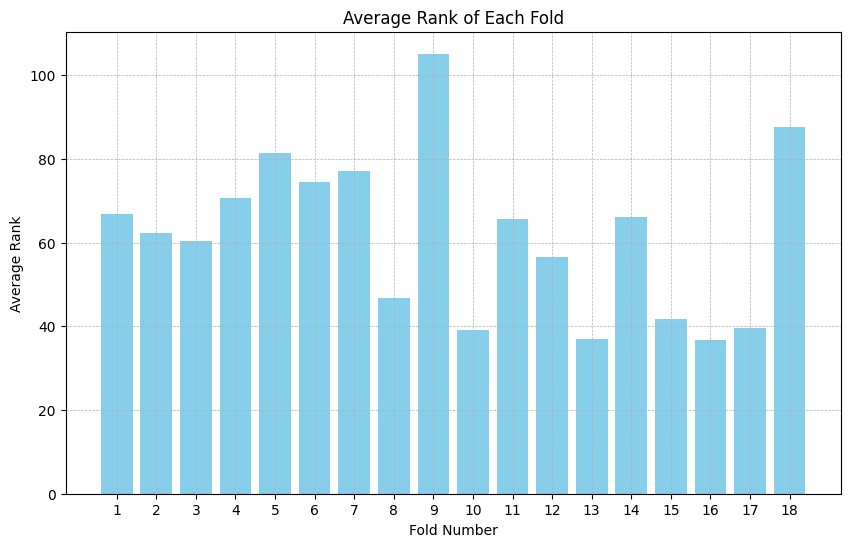

Successfully Decoded Concepts (Average Rank < 90.0):
do: 1.0
food: 1.0
time: 1.0
great: 2.0
laugh: 4.0
stupid: 5.0
lady: 6.0
left: 6.0
hair: 7.0
money: 7.0
ability: 8.0
big: 8.0
play: 8.0
relationship: 8.0
crazy: 9.0
music: 9.0
picture: 9.0
building: 10.0
construction: 10.0
feeling: 10.0
extremely: 11.0
dinner: 12.0
silly: 12.0
help: 13.0
light: 13.0
wear: 13.0
word: 13.0
read: 14.0
shape: 14.0
show: 14.0
soul: 14.0
damage: 15.0
fish: 15.0
skin: 15.0
successful: 15.0
team: 15.0
event: 16.0
quality: 16.0
art: 17.0
attitude: 17.0
mountain: 17.0
road: 18.0
dog: 19.0
unaware: 20.0
poor: 21.0
taste: 21.0
tried: 21.0
angry: 22.0
pain: 22.0
business: 24.0
plan: 25.0
science: 25.0
war: 25.0
student: 28.0
body: 29.0
sign: 29.0
broken: 31.0
pleasure: 31.0
tree: 31.0
carefully: 32.0
star: 33.0
economy: 34.0
level: 35.0
movement: 35.0
smiling: 35.0
solution: 35.0
election: 36.0
typical: 36.0
useless: 36.0
challenge: 37.0
law: 37.0
sound: 37.0
tool: 38.0
sell: 40.0
magic: 42.0
sad: 42.0
brain: 43.0

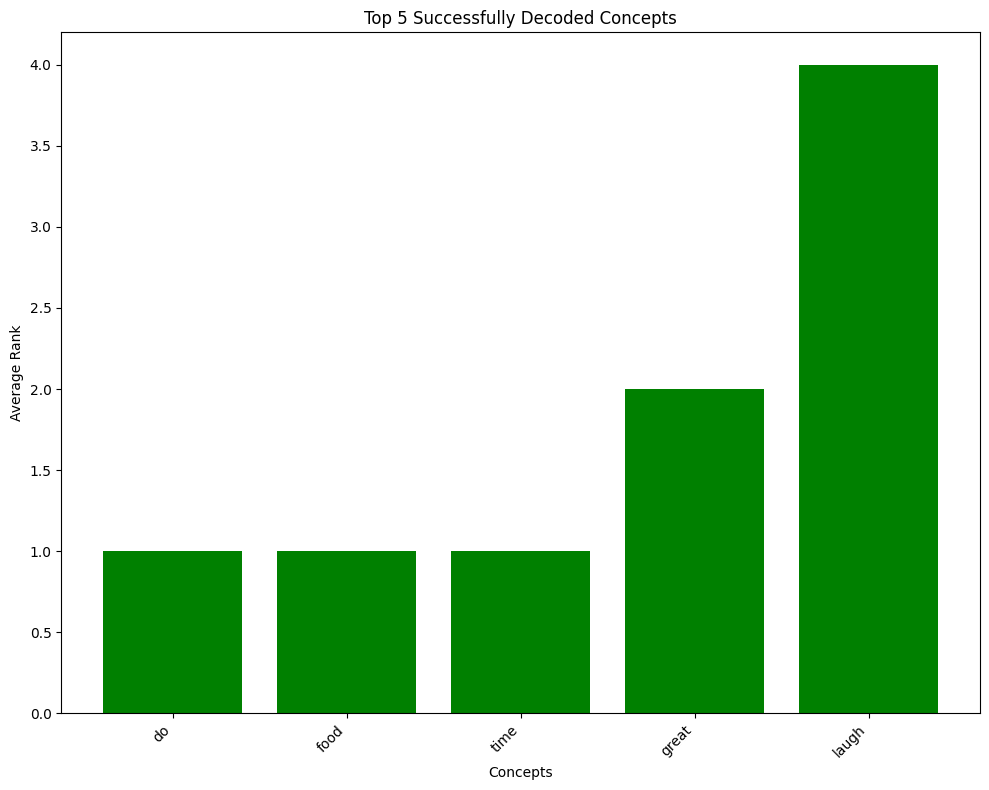

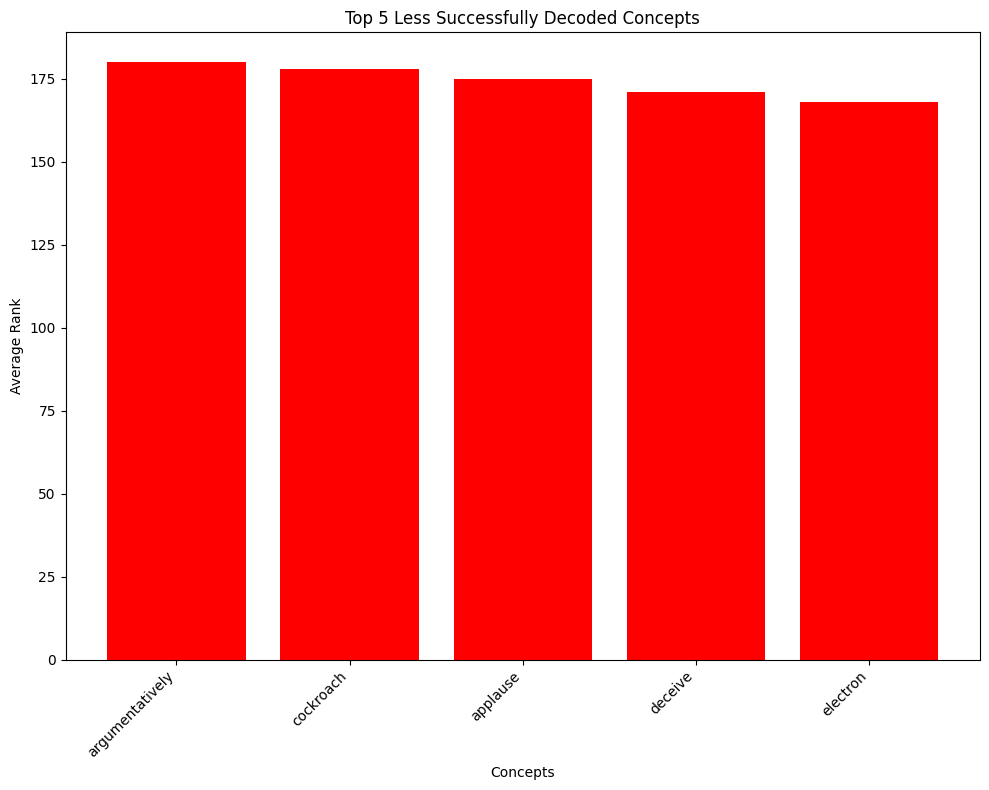

Number of successfully decoded concepts: 134
Number of less successfully decoded concepts: 46


In [ ]:
# Analyze GloVe performance
glove_ranks = performance_analysis(data, glove_vectors, glove_concepts)

Average rank of fold 1: 54.9
Average rank of fold 2: 79.8
Average rank of fold 3: 84.0
Average rank of fold 4: 58.7
Average rank of fold 5: 42.0
Average rank of fold 6: 54.0
Average rank of fold 7: 59.0
Average rank of fold 8: 60.5
Average rank of fold 9: 65.9
Average rank of fold 10: 50.7
Average rank of fold 11: 62.3
Average rank of fold 12: 62.1
Average rank of fold 13: 64.5
Average rank of fold 14: 54.9
Average rank of fold 15: 36.5
Average rank of fold 16: 73.3
Average rank of fold 17: 70.4
Average rank of fold 18: 57.0


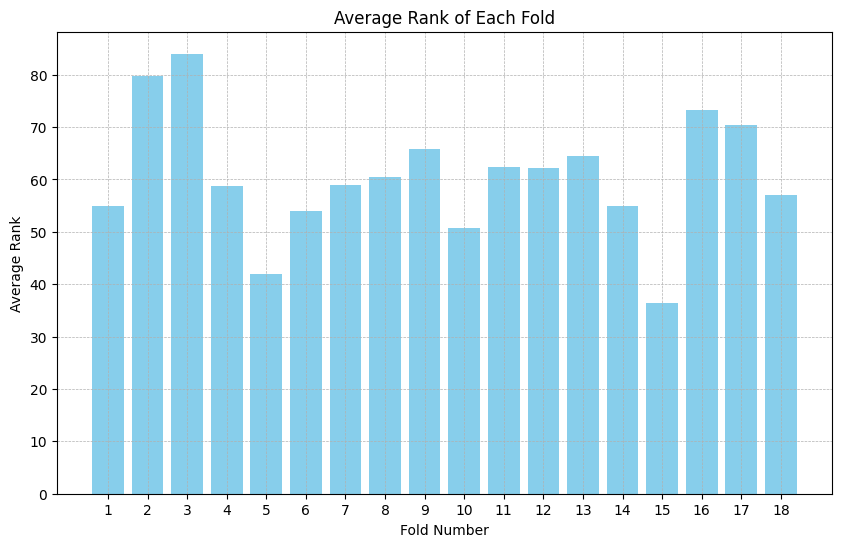

Successfully Decoded Concepts (Average Rank < 90.0):
laugh: 1.0
soul: 1.0
stupid: 1.0
emotion: 2.0
hair: 3.0
silly: 3.0
dig: 4.0
seafood: 4.0
smiling: 4.0
food: 5.0
liar: 5.0
sexy: 7.0
useless: 7.0
crazy: 8.0
do: 8.0
dressing: 9.0
skin: 9.0
wear: 9.0
bird: 10.0
personality: 10.0
music: 11.0
fish: 12.0
dessert: 13.0
art: 14.0
angry: 15.0
attitude: 15.0
big: 15.0
device: 15.0
dog: 15.0
feeling: 15.0
lady: 15.0
brain: 17.0
building: 17.0
reaction: 18.0
hurting: 20.0
cook: 21.0
sew: 21.0
apartment: 23.0
cockroach: 23.0
magic: 23.0
smart: 23.0
argumentative: 24.0
bag: 24.0
dinner: 24.0
pain: 24.0
medication: 25.0
philosophy: 25.0
taste: 25.0
pig: 27.0
play: 27.0
experiment: 29.0
willingly: 29.0
beer: 30.0
dangerous: 32.0
kindness: 32.0
tree: 32.0
mathematical: 33.0
shape: 33.0
mountain: 34.0
texture: 36.0
charming: 37.0
law: 37.0
gun: 38.0
economy: 40.0
investigation: 42.0
computer: 43.0
damage: 43.0
dedication: 43.0
impress: 43.0
sad: 43.0
team: 43.0
unaware: 43.0
doctor: 44.0
event: 44.0


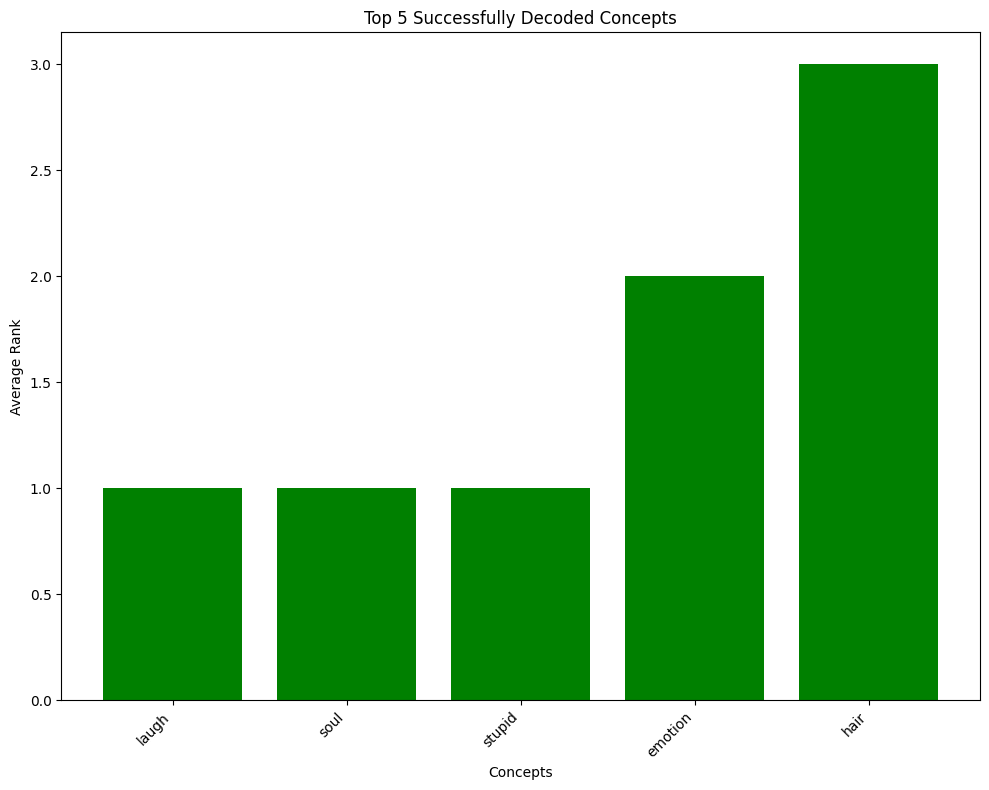

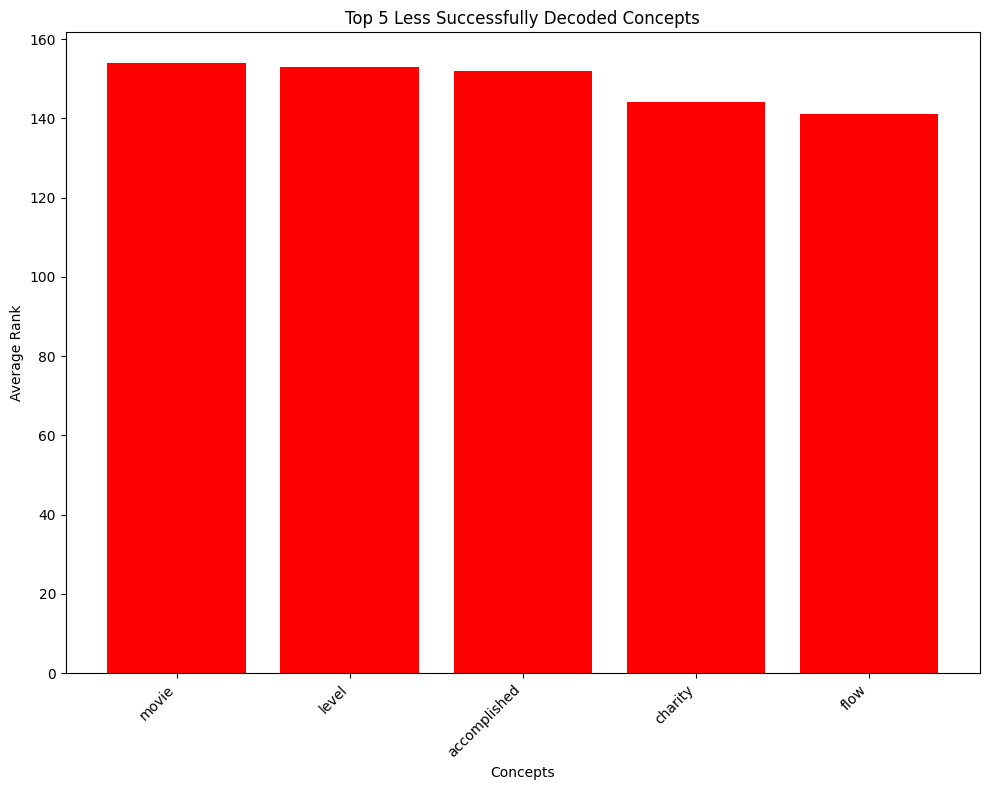

Number of successfully decoded concepts: 135
Number of less successfully decoded concepts: 45


In [ ]:
# Analyze Word2Vec performance
word2vec_ranks = performance_analysis(data, word2vec_vectors, word2vec_concepts)

Average rank of fold 1: 145.7
Average rank of fold 2: 171.4
Average rank of fold 3: 90.3
Average rank of fold 4: 165.6
Average rank of fold 5: 113.9
Average rank of fold 6: 158.2
Average rank of fold 7: 153.4
Average rank of fold 8: 156.2
Average rank of fold 9: 85.2
Average rank of fold 10: 149.2
Average rank of fold 11: 91.0
Average rank of fold 12: 117.7
Average rank of fold 13: 98.5
Average rank of fold 14: 128.7
Average rank of fold 15: 89.5
Average rank of fold 16: 103.6
Average rank of fold 17: 66.6
Average rank of fold 18: 157.1
Average rank of fold 19: 48.6
Average rank of fold 20: 157.5
Average rank of fold 21: 103.1
Average rank of fold 22: 126.6
Average rank of fold 23: 129.7
Average rank of fold 24: 128.6
Average rank of fold 25: 122.3
Average rank of fold 26: 166.5
Average rank of fold 27: 133.2
Average rank of fold 28: 98.4
Average rank of fold 29: 192.0
Average rank of fold 30: 133.9
Average rank of fold 31: 194.8
Average rank of fold 32: 81.5
Average rank of fold 33: 1

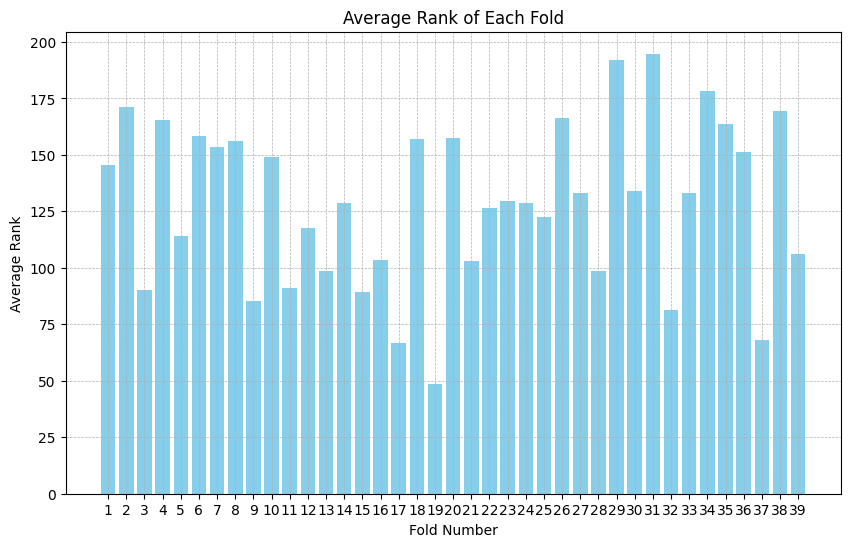

Successfully Decoded Concepts (Average Rank < 192.0):
A desk has a flat surface and can be made of wood, plastic or metal.: 1.0
Forks are used to lift food to the mouth or to hold food in place while cutting.: 1.0
People can go to public libraries and borrow books to take home for several weeks.: 1.0
A refrigerator is generally white and people often put magnets on its surface.: 1.0
The grooves make the bullets spin around the rifle axis as they fly through the air.: 1.0
Plants, animals and people must drink water in order to live.: 1.0
Hand grenades are thrown and timed to explode a bit after that.: 3.0
A mug is normally ceramic, but can also be made of metal or glass.: 3.0
Pressing a piano key causes a felt-tipped hammer to hit a vibrating steel string.: 3.0
Water is the most common liquid on Earth, covering 70% of its area.: 3.0
An adult male behaving immaturely is often referred to as a boy.: 4.0
An elephant has a long nose called a trunk, which can grab things or food.: 4.0
People

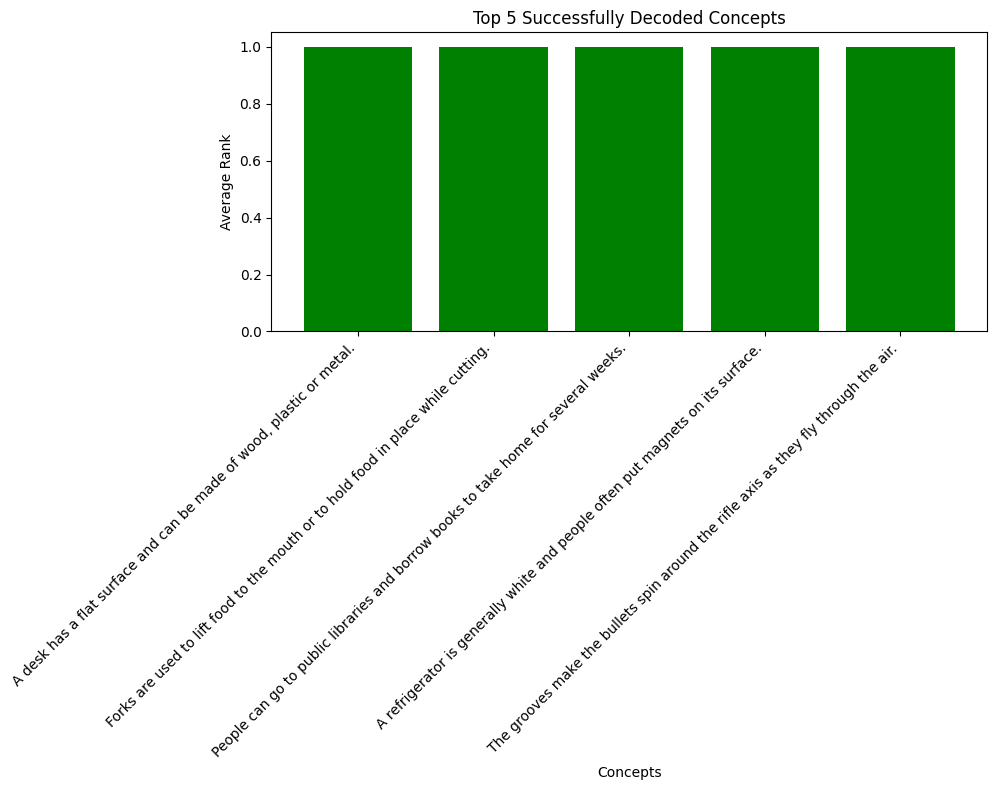

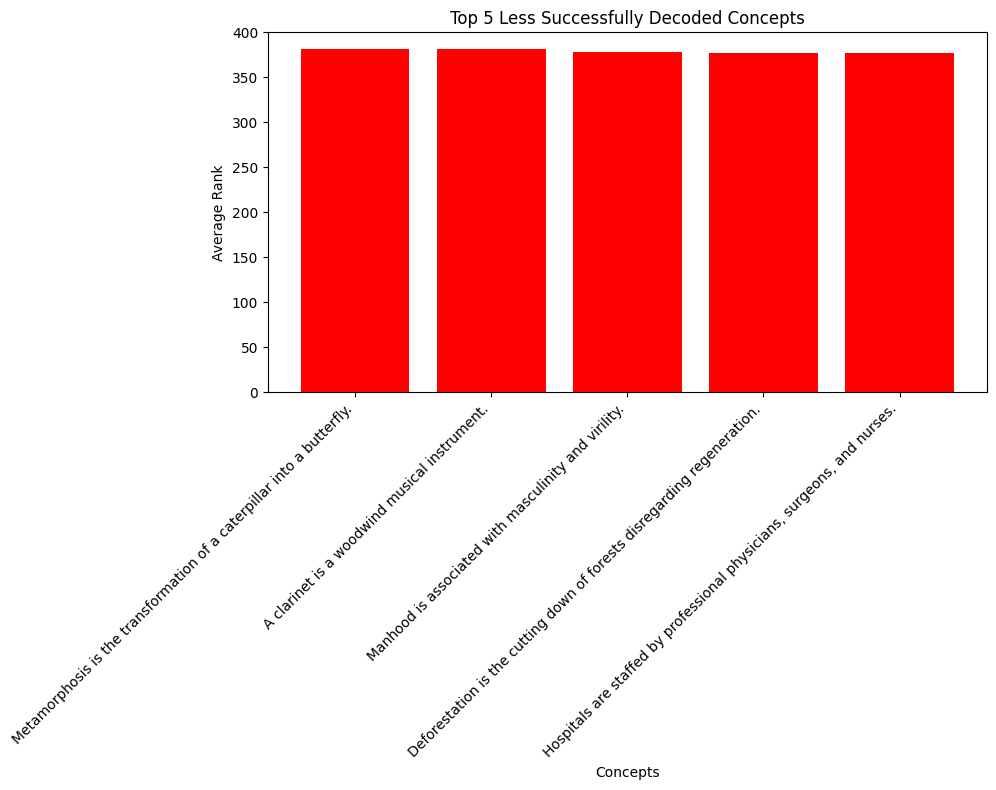

Number of successfully decoded concepts: 283
Number of less successfully decoded concepts: 101
Categories by Success:
furniture: 51.31
human: 78.81
drink_non_alcoholic: 79.00
body_part: 84.94
dwelling: 87.31
tool: 101.31
building_part: 101.56
kitchen_utensil: 101.62
weapon: 103.50
appliance: 109.44
insect: 119.75
place: 126.19
fruit: 127.44
bird: 131.81
animal: 139.00
fish: 141.38
disaster: 142.12
landscape: 155.19
crime: 157.88
vegetable: 169.81
vehicles_transport: 180.31
clothing: 183.75
music: 199.50
profession: 229.94


In [ ]:
# PART 2: Testing the GloVe based decoder on the datasets from analyses 2 & 3
exp2_concepts = []
with open(GDRIVE_DIR + '/stimuli_384sentences.txt', 'r') as concepts_file:
  for line in concepts_file:
    exp2_concepts += [line.strip()]
exp2_ranks = performance_analysis(exp2_fmri, exp2_vectors, exp2_concepts, concepts_to_categories = exp2_concepts_to_categories)

Average rank of fold 1: 175.9
Average rank of fold 2: 61.9
Average rank of fold 3: 68.5
Average rank of fold 4: 106.8
Average rank of fold 5: 91.8
Average rank of fold 6: 130.2
Average rank of fold 7: 107.2
Average rank of fold 8: 87.7
Average rank of fold 9: 43.2
Average rank of fold 10: 110.8
Average rank of fold 11: 73.7
Average rank of fold 12: 142.5
Average rank of fold 13: 88.4
Average rank of fold 14: 63.3
Average rank of fold 15: 92.8
Average rank of fold 16: 86.9
Average rank of fold 17: 105.1
Average rank of fold 18: 68.5
Average rank of fold 19: 122.9
Average rank of fold 20: 55.1
Average rank of fold 21: 113.4
Average rank of fold 22: 115.6
Average rank of fold 23: 86.6
Average rank of fold 24: 80.2
Average rank of fold 25: 127.66666666666667


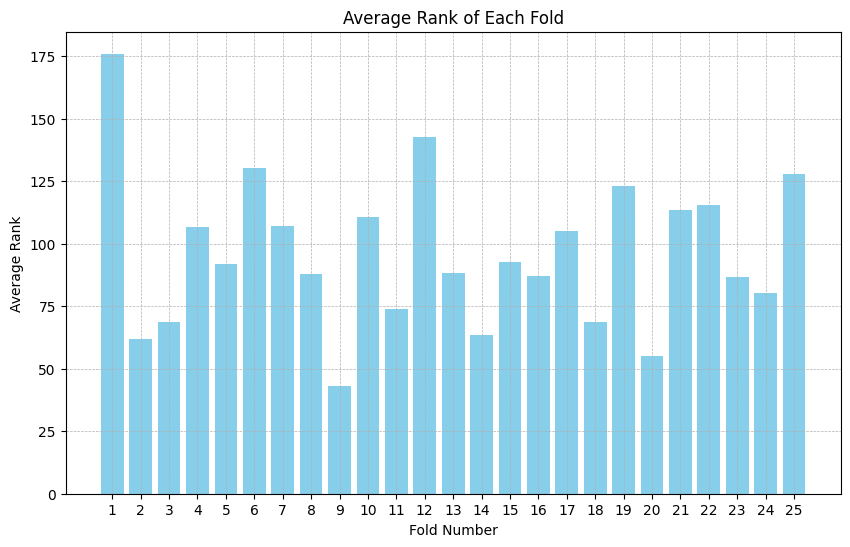

Successfully Decoded Concepts (Average Rank < 121.5):
Its large orange eyes are downright creepy, and look like they could pierce right through you.: 1.0
The polar bear will crawl quietly forward and freeze in place when the seal looks around.: 1.0
Some think ramps were built inside the pyramid's walls to raise stone blocks.: 1.0
In open or compound fractures, the broken bone has punctured the skin and produced an open wound.: 2.0
It's even worse when you are submerged in the frigid waters directly beneath the huge animal.: 2.0
Once they're comfortable with that, they can begin using ropes to safely climb vertical rock faces.: 2.0
He wanted to change things for the better.: 3.0
If not dealt with effectively, though, stress can take a real toll on health.: 3.0
The shirt should always be plain white and the tie should be black and match the jacket lapels.: 3.0
I found nature provides useful information, but more than is needed for a good painting.: 4.0
She uses digital animation to help 

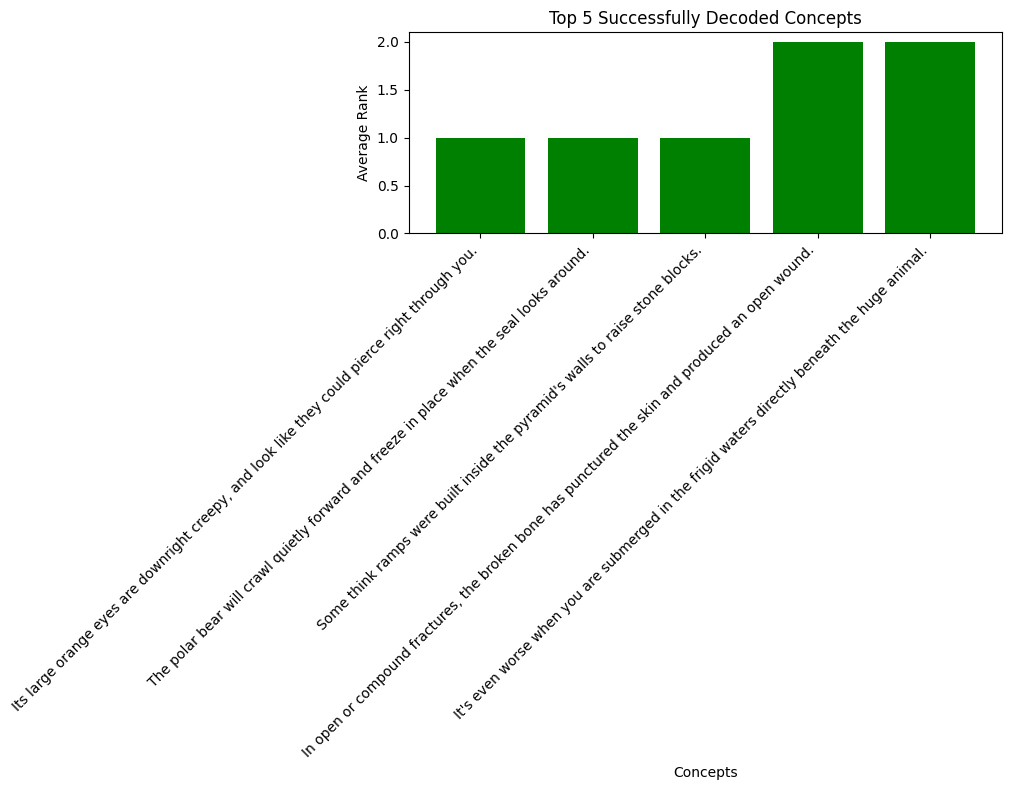

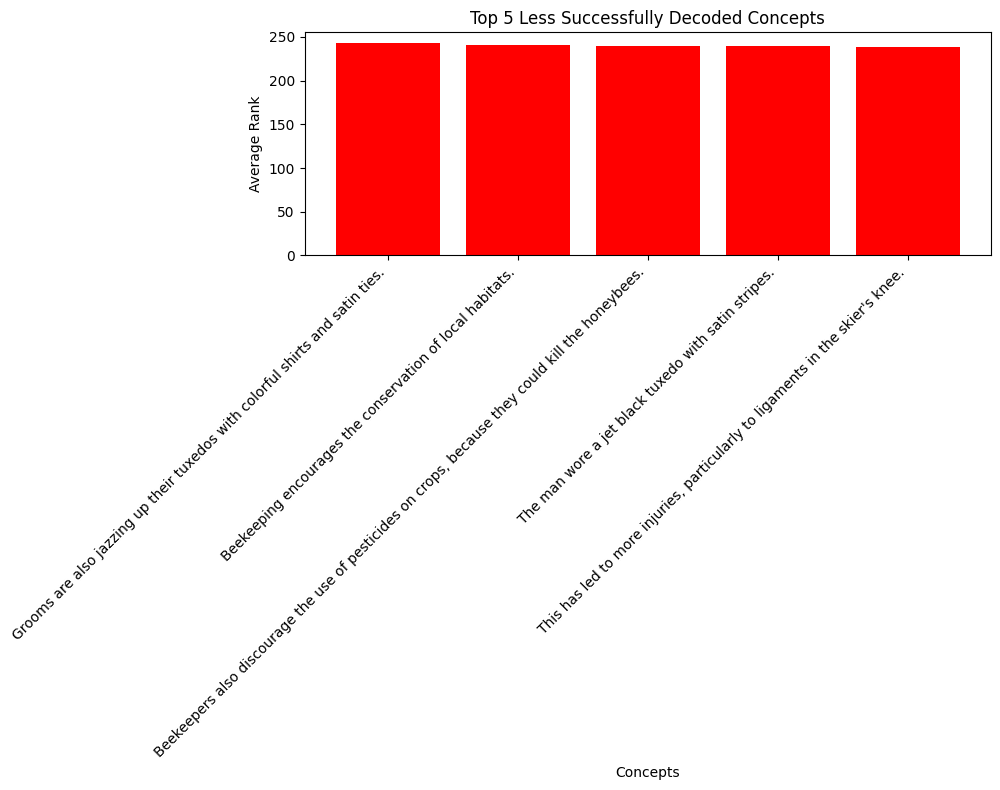

Number of successfully decoded concepts: 159
Number of less successfully decoded concepts: 84
Categories by Success:
law_school: 45.60
polar_bear: 52.60
dreams: 64.00
taste: 66.33
painter: 68.50
gambling: 70.10
stress: 74.60
computer_graphics: 76.20
bone_fracture: 84.55
rock_climbing: 86.18
blindness: 91.70
opera: 93.09
infection: 94.10
skiing: 99.90
ice_cream: 100.50
hurricane: 101.30
astronaut: 102.50
castle: 102.80
pharmacist: 109.80
pyramid: 122.00
owl: 135.30
lawn_mower: 136.40
tuxedo: 139.90
beekeeping: 163.27


In [ ]:
exp3_concepts = []
with open(GDRIVE_DIR + '/stimuli_243sentences.txt', 'r') as concepts_file:
  for line in concepts_file:
    exp3_concepts += [line.strip()]
exp3_ranks = performance_analysis(exp3_fmri, exp3_vectors, exp3_concepts, concepts_to_categories = exp3_concepts_to_categories)

Semi-structured Tasks

Average rank of fold 1: 77.9
Average rank of fold 2: 202.9
Average rank of fold 3: 78.2
Average rank of fold 4: 112.9
Average rank of fold 5: 52.0
Average rank of fold 6: 75.6
Average rank of fold 7: 82.9
Average rank of fold 8: 92.6
Average rank of fold 9: 125.5
Average rank of fold 10: 127.7
Average rank of fold 11: 92.5
Average rank of fold 12: 166.4
Average rank of fold 13: 119.3
Average rank of fold 14: 62.6
Average rank of fold 15: 138.1
Average rank of fold 16: 102.9
Average rank of fold 17: 45.7
Average rank of fold 18: 174.9
Average rank of fold 19: 101.2
Average rank of fold 20: 61.7
Average rank of fold 21: 166.1
Average rank of fold 22: 52.1
Average rank of fold 23: 93.6
Average rank of fold 24: 106.7
Average rank of fold 25: 100.3
Average rank of fold 26: 91.9
Average rank of fold 27: 90.7
Average rank of fold 28: 83.9
Average rank of fold 29: 153.6
Average rank of fold 30: 79.5
Average rank of fold 31: 140.1
Average rank of fold 32: 29.6
Average rank of fold 33: 88.4
Aver

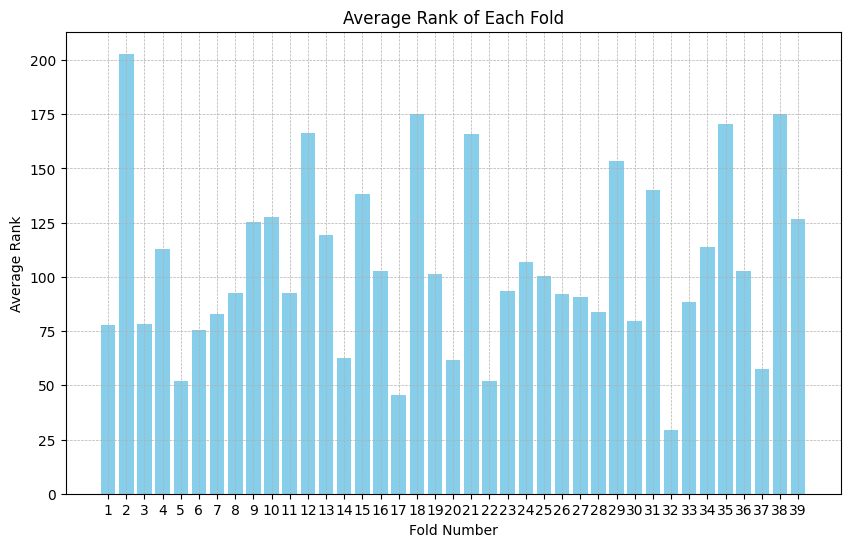

Successfully Decoded Concepts (Average Rank < 192.0):
A desk has a flat surface and can be made of wood, plastic or metal.: 1.0
Eagles have hooked beaks for tearing flesh, strong legs and sharp talons.: 1.0
Forks are used to lift food to the mouth or to hold food in place while cutting.: 1.0
Dairy products such as cheese and butter are made from milk.: 1.0
The grooves make the bullets spin around the rifle axis as they fly through the air.: 1.0
Apples have thin skin, a crisp, sweet pulp and seeds inside.: 2.0
A chair is a piece of furniture designed for people to sit on.: 2.0
A knife can be used to attack by slashing, stabbing or throwing.: 2.0
A mug is normally ceramic, but can also be made of metal or glass.: 2.0
A mug is thick and has a ring base for thermal insulation.: 2.0
The piano is a popular musical instrument played by means of a keyboard.: 2.0
Spears were used for stabbing or throwing when fighting in war.: 2.0
Many vultures have a bald head without feathers for losing heat.

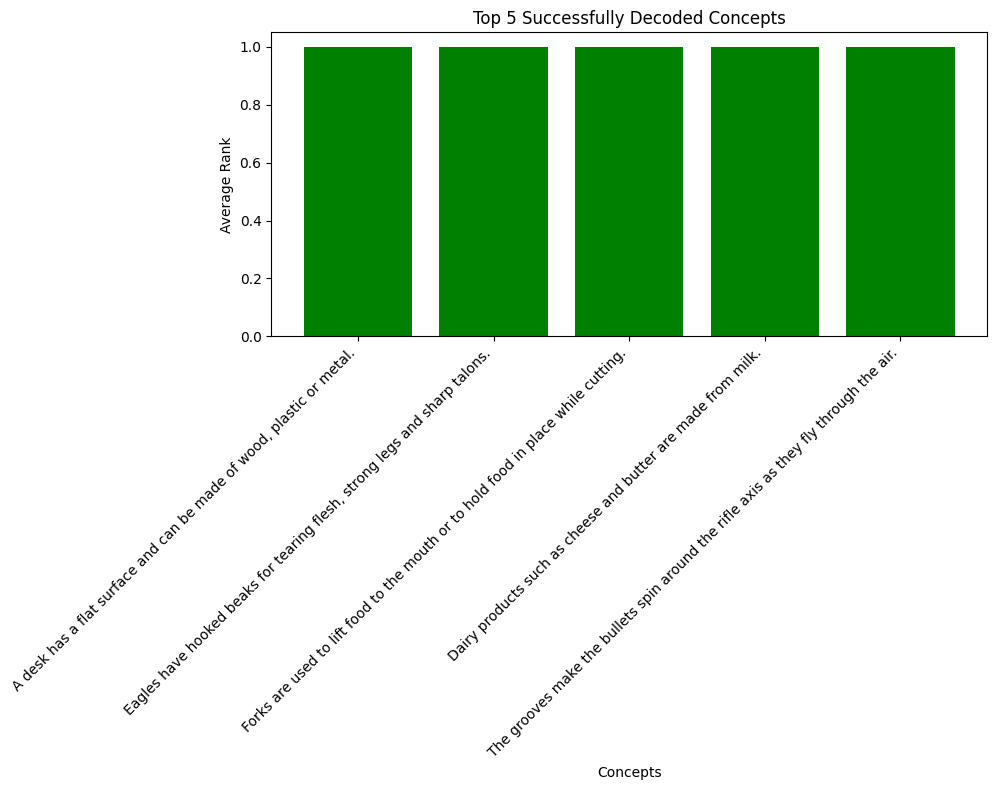

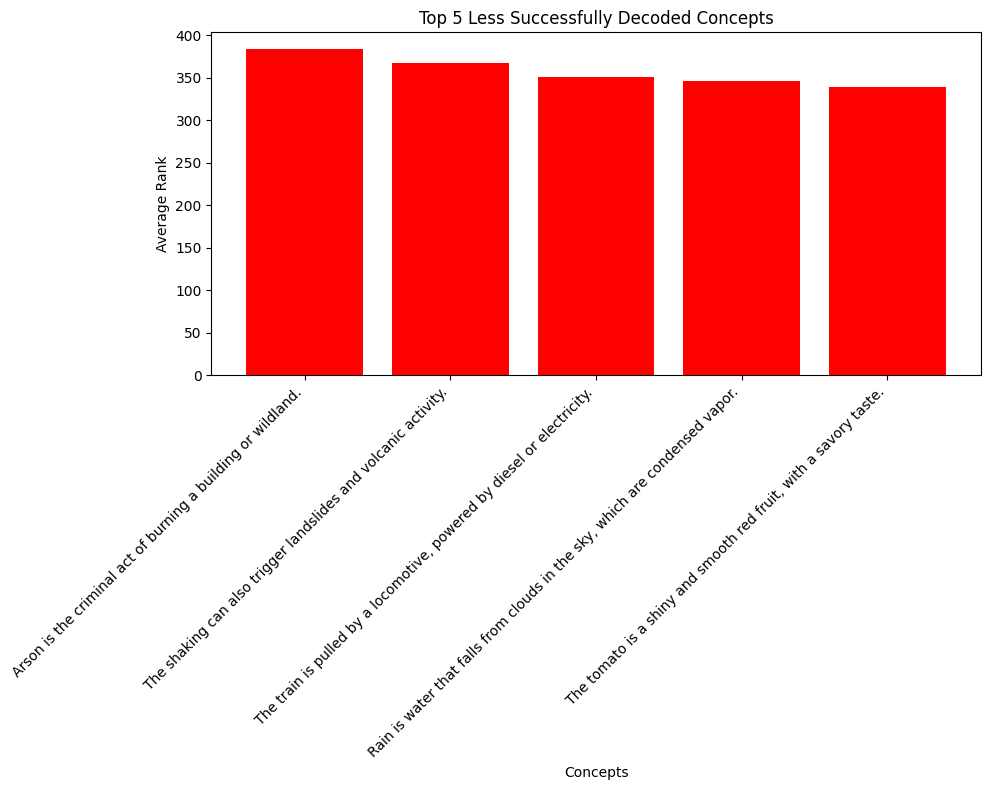

Number of successfully decoded concepts: 311
Number of less successfully decoded concepts: 73
Categories by Success:
furniture: 34.06
weapon: 37.00
kitchen_utensil: 39.25
tool: 58.94
insect: 64.25
human: 75.88
appliance: 80.69
fish: 84.94
fruit: 85.31
body_part: 89.62
bird: 95.75
vegetable: 100.25
clothing: 110.31
music: 118.62
disaster: 121.19
building_part: 121.94
animal: 124.69
dwelling: 132.19
landscape: 135.56
drink_non_alcoholic: 138.31
crime: 143.12
profession: 154.38
place: 181.12
vehicles_transport: 197.88


In [ ]:
# Testing the GloVe based decoder on the datasets from analyses 2 & 3
bert_exp2_ranks = performance_analysis(exp2_fmri, bert_exp2_vectors, exp2_concepts, concepts_to_categories = exp2_concepts_to_categories)

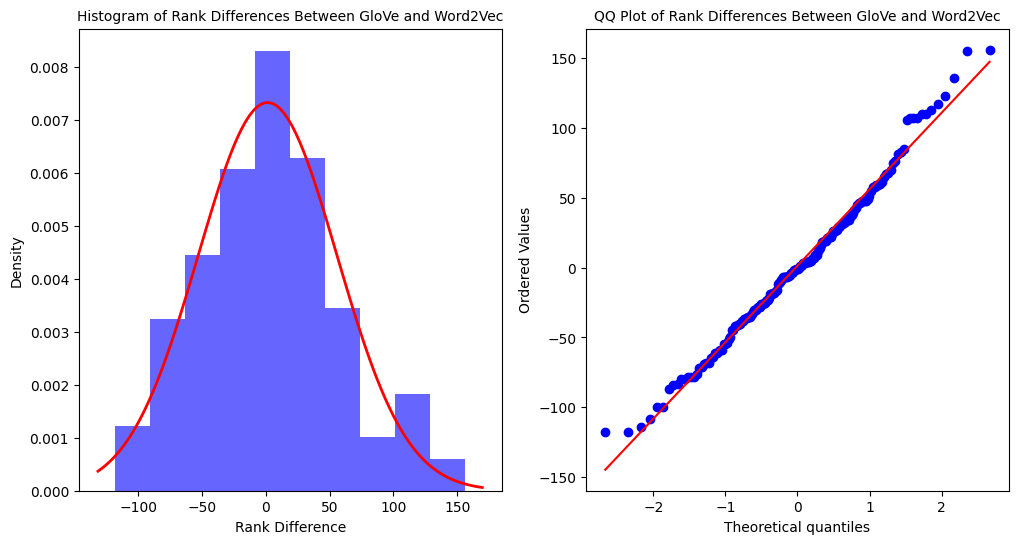

t-statistic: 0.3266
p-value: 0.7443
Fail to reject the null hypothesis: No significant difference between the models.


In [ ]:
import scipy.stats as stats

change = lambda x: 'argumentative' if x == 'argumentatively' else x
differences = [glove_ranks[concept] - word2vec_ranks[change(concept)] for concept in glove_ranks.keys()]

# Plot histogram with bell curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
count, bins, ignored = plt.hist(differences, bins=10, density=True, alpha=0.6, color='blue')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(differences), np.std(differences))
plt.plot(x, p, linewidth=2, color='red')
plt.title('Histogram of Rank Differences Between GloVe and Word2Vec', fontsize=10)
plt.xlabel('Rank Difference')
plt.ylabel('Density')

# Plot QQ plot
plt.subplot(1, 2, 2)
stats.probplot(differences, dist='norm', plot=plt)
plt.title('QQ Plot of Rank Differences Between GloVe and Word2Vec', fontsize=10)

plt.show()

# Perform one-sample t-test
t_stat, p_value = stats.ttest_1samp(differences, 0)

# Print t statistic and p value
print(f't-statistic: {t_stat:.4f}')
print(f'p-value: {p_value:.4f}')

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print('Reject the null hypothesis: Player one is significantly better.')
else:
    print('Fail to reject the null hypothesis: No significant difference between the models.')

Build a brain-encoder model

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import warnings

# Suppress specific warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

def compute_beta_estimates(design_matrix, voxel_response, inverse_design_matrix):
    """Compute the beta estimates for a given voxel's response."""
    return np.dot(inverse_design_matrix, np.dot(design_matrix.T, voxel_response))

def make_predictions(design_matrix, beta_estimates):
    """Generate predictions for a voxel based on its beta estimates."""
    return np.dot(design_matrix, beta_estimates)

def calculate_r_squared(voxel_response, predictions):
    """Calculate the R-squared value for voxel predictions."""
    ss_res = np.sum((voxel_response - predictions) ** 2)
    ss_tot = np.sum((voxel_response - np.mean(voxel_response)) ** 2)
    return 1 - (ss_res / ss_tot)

def calculate_cosine_similarity(voxel_response, predictions):
    """Calculate the cosine similarity between actual and predicted voxel responses."""
    return cosine_similarity(voxel_response.reshape(1, -1), predictions.reshape(1, -1))[0][0]

def process_voxel_data(neural_responses, design_matrix):
    warnings.simplefilter(action='ignore', category=FutureWarning)
    num_features = neural_responses.shape[1]  # Using features as the number of voxels
    r2_scores, significant_voxels, all_cosine_similarities = [], [], []
    inverse_design_matrix = np.linalg.inv(design_matrix.T.dot(design_matrix))

    for feature_index in tqdm(range(num_features), desc='Processing features'):
        voxel_response = neural_responses[:, feature_index]
        beta_estimates = compute_beta_estimates(design_matrix, voxel_response, inverse_design_matrix)
        predictions = make_predictions(design_matrix, beta_estimates)
        r_squared = calculate_r_squared(voxel_response, predictions)
        cosine_score = calculate_cosine_similarity(voxel_response, predictions)

        r2_scores.append(r_squared)
        all_cosine_similarities.append(cosine_score)
        if r_squared > 0.8:
            significant_voxels.append(feature_index)

    return r2_scores, significant_voxels, all_cosine_similarities

def analyze_neural_activity(data_matrix, embedding_vectors):
    if not np.issubdtype(data_matrix.dtype, np.number):
        data_matrix = data_matrix.astype(float)
        print("Converted data matrix to float.")

    if not np.issubdtype(embedding_vectors.dtype, np.number):
        embedding_vectors = embedding_vectors.astype(float)
        print("Converted embedding vectors to float.")

    intercept = np.ones((data_matrix.shape[0], 1))
    full_design_matrix = np.hstack([intercept, embedding_vectors])
    print("Intercept shape:", intercept.shape)
    print("Full design matrix shape:", full_design_matrix.shape)

    try:
        r2_scores, significant_voxels, cosine_similarities = process_voxel_data(data_matrix, full_design_matrix)
        summarize_results(r2_scores, significant_voxels, cosine_similarities)
        return r2_scores
    except Exception as e:
        print("Error during processing:", str(e))
        return None

def summarize_results(r2_scores, significant_indices, cosine_similarities):
    average_cosine = np.mean(cosine_similarities)
    percent_significant = 100 * len(significant_indices) / len(r2_scores)
    print("Average Cosine Similarity across all voxels:", average_cosine)
    print("Percentage of significant voxels:", percent_significant)
    print("Number of significant voxels:", len(significant_indices))


In [ ]:
r2_scores_glove_analysis_2 = analyze_neural_activity(exp2_fmri, exp2_vectors)

Converted embedding vectors to float.
Intercept shape: (384, 1)
Full design matrix shape: (384, 301)


Processing features: 100%|██████████| 185866/185866 [05:02<00:00, 614.71it/s]


Average Cosine Similarity across all voxels: 0.9057797591051041
Percentage of significant voxels: 55.478140165495574
Number of significant voxels: 103115


In [ ]:
r2_scores_bert_analysis_2 = analyze_neural_activity(exp2_fmri, bert_exp2_vectors)

Intercept shape: (384, 1)
Full design matrix shape: (384, 385)


Processing features: 100%|██████████| 185866/185866 [05:19<00:00, 581.80it/s]

Average Cosine Similarity across all voxels: 0.9954477884742476
Percentage of significant voxels: 99.36136786717313
Number of significant voxels: 184679


In [ ]:
def plot(r2_scores_glove,r2_scores_bert,exp_fmri, title):
  voxel_indices = np.arange(1, exp_fmri.shape[1] + 1)
  plt.figure(figsize=(10, 8))
  plt.plot(voxel_indices, r2_scores_bert, label='BERT R2', color='orange')
  plt.plot(voxel_indices, r2_scores_glove, label='GloVe R2', color='green')
  plt.legend()
  plt.xlabel('Voxel')
  plt.ylabel('R2 Score')
  plt.title(f'Comparison of R2 Scores for BERT and GloVe Embeddings from {title}')
  plt.show()

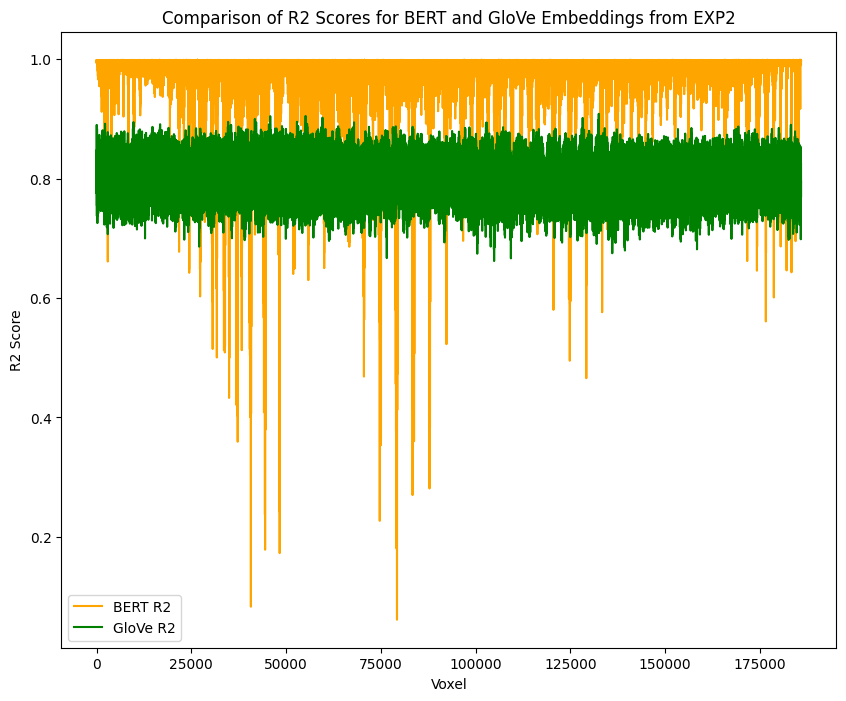

In [ ]:
plot(r2_scores_glove_analysis_2,r2_scores_bert_analysis_2,exp2_fmri,'EXP2')